In [1]:
import warnings
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("white")

ROOT_PATH = Path("..")

In [2]:
# Load Data
_df = pd.read_csv(ROOT_PATH / "data/raw/metadata.csv")
svc_ids = pd.read_json(ROOT_PATH / "data/raw/song_vs_call.json").squeeze()
svc_df = _df.loc[_df.id.isin(svc_ids)].copy()

# Add response variable
type_col = svc_df.type.str.lower().str.replace(" ", "").str.split(",")
svc_df["pred"] = type_col.apply(lambda l: "call" in l).astype(int)

Number of rows: 5800
Percent NaN in svc_df.date: 0.52%


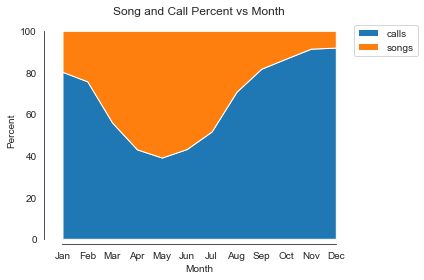

In [3]:
# Build song vs call over time of year heat map
# We go through all of the labels and aggregate them by month, and then plot an area graph that
# will show the break up between the two
svc_df.date = pd.to_datetime(svc_df.date, format="%Y-%m-%d", errors="coerce")
percent_nan = svc_df.date.isnull().sum() * 100 / len(svc_df)
print(f"Number of rows: {len(svc_df)}")
print(f"Percent NaN in svc_df.date: {percent_nan:.2f}%")
call_info = (
    svc_df[["date", "pred"]]
    .groupby(svc_df.date.dt.month)
    .agg({"pred": ["sum", "count"]})
)
call_info.columns = call_info.columns.get_level_values(1)  # drop the top index
call_info["call_pct"] = call_info["sum"] / call_info["count"] * 100
call_info["song_pct"] = 100 - call_info.call_pct
call_info.head()

# Convert integers months to the string rep
x = (
    call_info.index.to_series()
    .apply(lambda m_num: datetime(year=1, month=int(m_num), day=10).strftime("%b"))
    .tolist()
)
y = call_info[["call_pct", "song_pct"]].T.values.tolist()
f, ax = plt.subplots()
ax.grid(False)
ax.stackplot(x, y, labels=["calls", "songs"])
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
sns.despine(f, ax, offset=5, trim=True)
ax.set_xlabel("Month")
ax.set_ylabel("Percent")
ax.set_title("Song and Call Percent vs Month")
f.tight_layout()
fig_name = "svc_vs_month.png"
f.savefig(f"assets/{fig_name}", dpi=150)

,count
state,
Arizona,847
California,760
Colorado,483
Tennessee,454
Michigan,252


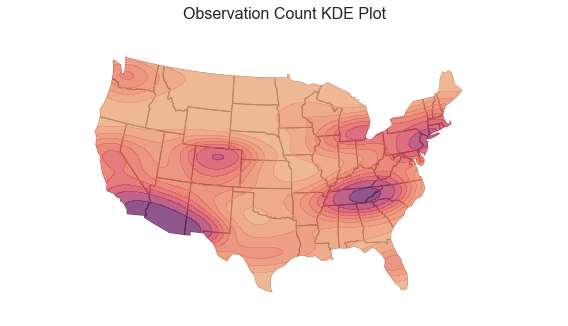

In [4]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path("contiguous_usa"))
geo_df = gpd.GeoDataFrame(
    svc_df, geometry=gpd.points_from_xy(svc_df.lng, svc_df.lat)
).dropna(subset=["lng", "lat"])
geo_df.set_crs(epsg=4326, inplace=True)  # Long lat CRS

geo2_df = gpd.sjoin(geo_df, contiguous_usa, how="left", op="within").dropna(
    subset=["state"]
)

ax = gplt.polyplot(contiguous_usa, edgecolor="black", projection=gcrs.AlbersEqualArea())

# Hide UserWarning and FutureWarning (generated by geoplot not being updated)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", FutureWarning)
    gplt.kdeplot(
        geo2_df,
        cmap=sns.color_palette("flare", as_cmap=True),
        shade=True,
        clip=contiguous_usa,
        shade_lowest=True,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title("Observation Count KDE Plot", fontsize=16)
    f = plt.gcf()
    f.tight_layout()
    fig_name = "svc_sample_density_usa.png"
    f.savefig(f"assets/{fig_name}", dpi=150)

geo2_df[["id", "state"]].groupby("state").count().nlargest(5, columns=["id"]).rename(
    columns={"id": "count"}
)

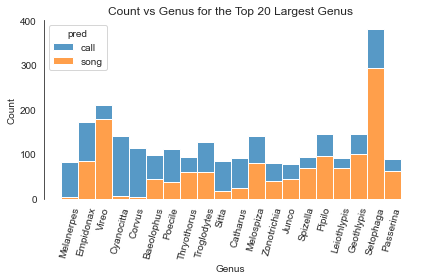

In [5]:
N = 20
filter_gen = svc_df.gen.value_counts().nlargest(N).index.tolist()
svc_df.pred = svc_df.pred.replace({0: "song", 1: "call"})
g = sns.histplot(
    data=svc_df[svc_df.gen.isin(filter_gen)], x="gen", hue="pred", multiple="stack"
)
f = plt.gcf()
sns.despine(f, g, bottom=True)
plt.setp(g.get_xticklabels(), rotation=75)
g.set_xlabel("Genus")
g.set_title(f"Count vs Genus for the Top {N} Largest Genus")
f.tight_layout()
fig_name = "svc_count_vs_genus.png"
f.savefig(f"assets/{fig_name}", dpi=150)